In [3]:
% reset

import numpy as np
import scipy 
from scipy.io import loadmat #be used to get data from .mat document 
from scipy import signal #scipy: scientific python, be used to scientific computation and signal is used to procsess signal 

import pywt #python wavelate transformation 
from os import walk #walk: be used to read file name

import sklearn
from sklearn.decomposition import FastICA


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [78]:
import matplotlib #be used to plot 
matplotlib.use('Agg')
import matplotlib.pyplot as plt 

def plt_allch(sig,c):
    num_ch = sig.shape[1]
    fig = plt.figure(figsize=(30,30))
    for i in range(num_ch):
        plt.subplot(num_ch, 1, i+1)
        plt.plot(range(sig.shape[0]),sig[:,i],c)
    return fig

In [79]:
num_ch = 0 #number of channels
raw_data_length = 0 #

def set_globvar_to_one():
    global num_ch    # Needed to modify global copy of globvar
    num_ch = 16
    global raw_data_length    # Needed to modify global copy of globvar
    raw_data_length = 400*60*10

def print_globvar():
    print(num_ch,raw_data_length)     # No need for global declaration to read value of globvar

set_globvar_to_one()
print_globvar()       # Prints 1

(16, 240000)


In [80]:
'''read filenames of raw data'''
def read_fn(mypath):
    f = []
    cnt_szf = 0
    # print(walk(mypath))
    for (dirpath, dirnames, filenames) in walk(mypath):
        print(len(filenames))
        for fn in filenames:
            if fn[-3:]=='mat':
                f.extend([fn])
            if fn[-5]=='1': # seizure label
                cnt_szf = cnt_szf + 1
        break
    file_path = []
    for x in f:
        file_path.extend([dirpath+'/'+x])

    ttnf = len(file_path)
    print('read_fn: total number of interictal files:',ttnf - cnt_szf)
    print('read_fn: total number of preictal files:',cnt_szf)
    return ttnf,cnt_szf,file_path

In [81]:
'''eigenvalue of correlation matrix in frequency domain'''

def eig_cor_fft(rawdata_tenmin,window):
    def fft(time_data):
        return (np.absolute(np.fft.rfft(time_data)[window]))
    tr = []
    for i in range(16):
        tr.append(fft(rawdata_tenmin[:,i]))
        sklearn.preprocessing.scale(tr)
    tn = np.asarray(tr)
#     print(tn.shape)
    corr_matrix = np.corrcoef(tn)
    try:
        eigenvalues = np.absolute(np.linalg.eig(corr_matrix)[0])
    except:
        print(corr_matrix)
    eigenvalues.sort()
    return eigenvalues
# print(eigenvalues.shape)


In [82]:
'''computing features'''
def compute_feature(person,case,n_hours,sourcepath,destpath,ICA,window):
    for hour_idx in range(n_hours):
        feadata_tenmin = []
        for time_clip in range(6):
            time_idx = time_clip + hour_idx*6 + 1
            tmp = [sourcepath,'/',str(person),'_',str(time_idx),'_',str(case),'.mat']
    #         print(tmp)
            seizure_fn = ''.join(tmp)
            try:
                tmpdata = loadmat(seizure_fn)['dataStruct']
            except:
                print(seizure_fn,'broken!!!')
                continue
            raw_data = tmpdata[0][0][0] # inside structure
            if (np.count_nonzero(raw_data)):
                if ICA:
                    try:
                        ica = FastICA()
                        raw_data = ica.fit_transform(raw_data)  # Reconstruct signals
                    except:
                        print(seizure_fn,'ica failed!!!!')
                        continue
                eigs = eig_cor_fft(raw_data,window)
            else:
                eigs = np.zeros(np.asarray(window).shape)
                print('all zero file found!')        
            feadata_tenmin.append(eigs)                 
        fname = [destpath,'/',str(person),'_',str(hour_idx),'_',str(case)] #person_idx, hour_idx, non-seizure
        feaname = ''.join(fname)
        feadata = np.asarray(feadata_tenmin)
        print(feaname)
        np.save(feaname,feadata)


In [83]:
'''train_and_test_data_labels_safe'''
import csv
data_name = []
data_safe = []
data_class = []
with open('./datafiles/train_and_test_data_labels_safe.csv', 'rb') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in csvreader:
        data_class = data_class + [int(row[0][-3])]
        data_safe = data_safe + [int(row[0][-1])]
        data_name = data_name + [row[0][0:-8]]
print(len(data_class),len(data_safe),len(data_name))

(6325, 6325, 6325)


In [84]:
'''feature extraction entrance'''
person = 1 #only for training data
ICA = 0
window = range(10,50) # only consider 1hz to 60 hz

datapath = ['/home/hope-yao/Documents/kaggle/projects/datafiles/train_',str(person)]
sourcepath = ''.join(datapath)
[ttnf,cnt_szf,file_path] = read_fn(sourcepath)

feapath = ['/home/hope-yao/Documents/kaggle/projects/featurefiles/train_',str(person)]
destpath = ''.join(feapath)

print('sourcepath: ',sourcepath)
print('destpath: ',destpath)
for case in range(2): # seizure or non-seizure
    if case==0:
        n_file = ttnf - cnt_szf
        n_hours = int(np.ceil(n_file/6.0)) #in case of missing file, like 1_45_1
    else:
        n_hours = int(np.ceil(cnt_szf/6.0)) #in case of missing file, like 1_45_1
    compute_feature(person,case,n_hours,sourcepath,destpath,ICA,window) #



1302
('read_fn: total number of interictal files:', 1152)
('read_fn: total number of preictal files:', 150)
('sourcepath: ', '/home/hope-yao/Documents/kaggle/projects/datafiles/train_1')
('destpath: ', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1')
/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_0_0
/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_1_0


KeyboardInterrupt: 

In [85]:
'''read feature data'''
person = 1
feapath = ['/home/hope-yao/Documents/kaggle/projects/featurefiles/train_',str(person)]
destpath = ''.join(feapath)
f = []
for (dirpath, dirnames, filenames) in walk(destpath):
    for fn in filenames:
        if fn[-3:]=='npy':
            f.extend([fn])
    break
file_path = []
for x in f:
    file_path.extend([dirpath+'/'+x])

ttnf = len(file_path)
print('total number of file found:',ttnf)

n = ttnf #ttnf
fea_sig = []
fea_label = []
for i,fp in enumerate(file_path[0:n]):
    idx_tmp = int(fp[fp.rfind('/')+3:len(fp)-6])
    if fp[-5]:
        if person ==1:
            flg_safe = data_safe[1152 + idx_tmp * 6]
        else:
            print('error')
            break
    else:
        flg_safe = data_safe[idx_tmp * 6]
        
    # skip contaminated data
    if flg_safe==0:
        continue
        
    fea_data = np.load(fp)
    tmp = fea_data # inside structure
    if  tmp.shape==(6,16):  # check signal size
        if (np.count_nonzero(tmp)):
            if 0:
                tmp_onehour = []
                for i in range(tmp.shape[0]):
                    tmp_onehour = tmp_onehour + tmp[i,:].tolist()
                fea_sig.append(tmp_onehour) #nf ,raw_data_length,num_ch
                fea_label.append(int(fp[-5]))
            else:
                for i in range(tmp.shape[0]):
                    fea_sig.append(tmp[i,:]) #nf ,raw_data_length,num_ch
                    fea_label.append(int(fp[-5]))               
    else:
        print('file with missing clip found!',fp)
fea_sig = np.asarray(fea_sig)
print(fea_sig.shape)
print(len(fea_label))


('total number of file found:', 217)
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_191_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_155_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_188_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_160_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_181_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_31_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_74_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/featurefiles/train_1/1_137_0.npy')
('file with missing clip found!', '/home/hope-yao/Documents/kaggle/projects/f

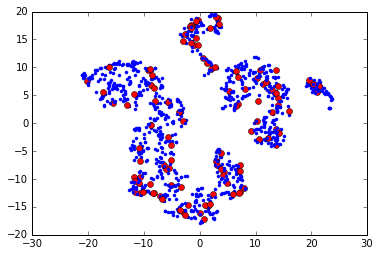

In [9]:
'''T-SNE Visualization in feature space'''
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
T = model.fit_transform(fea_sig) 

# from mpl_toolkits.mplot3d import Axes3D
# %pylab qt
%matplotlib inline

fig = plt.figure()
# ax = plt.axes(projection='3d')
for i,k in enumerate(fea_label):
    if k==0:
        plt.plot(T[i,0],T[i,1],'b.')
#         ax.scatter(T[i,0],T[i,1],T[i,2],c='b')
    else:
        plt.plot(T[i,0],T[i,1],'ro')
#         ax.scatter(T[i,0],T[i,1],T[i,2],c='r')
        
        

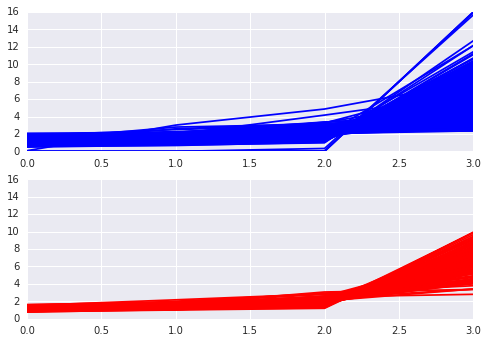

In [86]:
for i,k in enumerate(fea_label):
    sig = fea_sig[i,:]
    if k==0:
        ax1 = plt.subplot(2,1,1)
        ax1.plot(range(4),sig[len(sig)-4:len(sig)+1],'b')
    else:
        ax2 = plt.subplot(2,1,2)
        ax2.plot(range(4),sig[len(sig)-4:len(sig)+1],'r')
ax1.set_ylim([0,16])
ax2.set_ylim([0,16])
plt.show()


In [88]:
'''data balance and training/testing split'''
from imblearn.over_sampling import SMOTE
from random import sample

# Apply regular SMOTE
sm = SMOTE(kind='regular')
data_balance, label_balance = sm.fit_sample(fea_sig, fea_label)

l = len(data_balance) #length of data 
f = int(0.1*l)  # 10% for testing
indices = sample(range(l),f)

data_train = data_balance[indices]
label_train = label_balance[indices]

data_test = np.delete(data_balance,indices)
label_test = np.delete(label_balance,indices)


In [75]:
'''Random Forest'''
# specify parameters and distributions to sample from

#from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from time import time
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
clf = RandomForestClassifier(n_estimators=200,n_jobs=-1)

n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()


random_search.fit(data_train, label_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
#report(random_search.cv_results_)


RandomizedSearchCV took 54.79 seconds for 20 candidates parameter settings.


ROC score    : 0.7378.


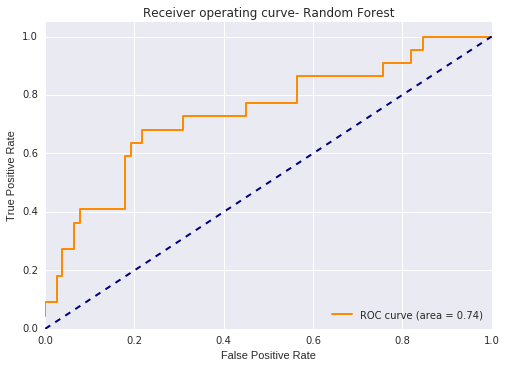

In [89]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

data_test = fea_sig[0:100]
label_test = fea_label[0:100]

y_pred = random_search.predict(data_test)
RFprobaR=random_search.predict_proba(data_test)
print ("ROC score    : {:.4f}.".format(roc_auc_score(np.array(label_test), np.array(RFprobaR[:,1]))))

fpr, tpr, _ = roc_curve(label_test, RFprobaR[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve- Random Forest')
plt.legend(loc="lower right")
plt.show()

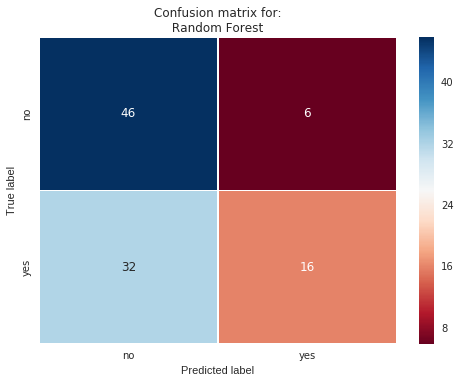

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for a model
cm=confusion_matrix(y_pred,label_test)

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='RdBu', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], linewidth=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(" Random Forest "))

In [19]:
'''visualization''' 

for i,l in enumerate(label[0:5]):
    sig = raw_sig[i,:,:]
    if l==1:
        fig = plt_allch(sig,'r')
        s = ['./vis/seizure/',str(i),'.png']
        ss = ''.join(s)
        fig.savefig(ss)  
    else:
        fig = plt_allch(sig,'b')
        s = ['./vis/non-seizure/',str(i),'.png']
        ss = ''.join(s)
        fig.savefig(ss)  

# cnt = 0
# for i,p in enumerate(sig):
#     if not np.count_nonzero(p):
#         sig[j,:,i] =  (sig[j-1,:,i] + sig[j+1,:,i]) / 2
# #             print(j,i)
#         cnt = cnt + 1
# print(cnt)

# cnt = 0
# for zero_value in raw_sig:
#     for i in range(len(raw_sig[0,0,:])):
#         if zero_value[:,i].all == (np.asarray([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])).all:
#             zero_value[:,i] =  (zero_value[:,i+1] + zero_value[:,i-1]) / 2
#             cnt = cnt + 1
# print(cnt)

NameError: name 'label' is not defined

In [147]:
'''Wavelet''' 

def single_channel_dwt(sig):
#     input 240000
    coeffs = pywt.wavedec(sig, 'db2', level=6)
    cA2, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    return cD6
#     coeffs = pywt.wavedec(sig, 'db1', level=6)
#     cA2, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
#     return cD6

def multi_channel_dwt(sig):
#     input: 240000 * 16
#     return: k * 16
    F = []
    for s_sig in sig.T:
        cd = single_channel_dwt(s_sig)
        F.append(cd)
#     return np.asarray(F)
    return F


In [148]:
print(raw_sig.shape)
tmp = multi_channel_dwt(raw_sig[5,:,:])
len(tmp[0])

(1267, 240000, 16)


3752